<a href="https://colab.research.google.com/github/zrruziev/Deep_Learning_Practice/blob/main/TDC/C4_W3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

##Generating the data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

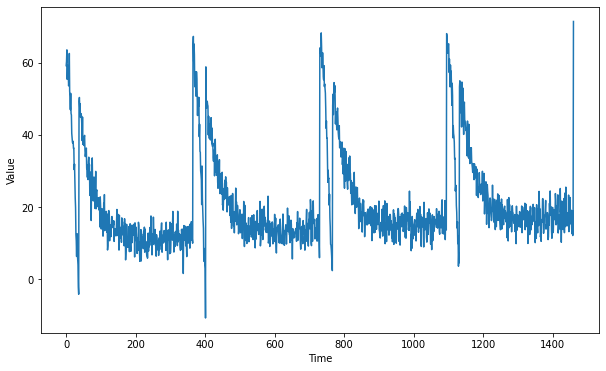

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series



# Save all 'global' variables within the G class (G stands for global) 
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


# Plot the generated series
plt.figure(figsize=(10,6))
plot_series(G.TIME, G.SERIES)
plt.show()

##Processing the data


In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_val = time[time_step:]
    series_val = series[time_step:]
    return time_train, series_train, time_val, series_val

# Split the dataset
time_train, series_train, time_val, series_val = train_val_split(G.TIME, G.SERIES)


In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda w: (w[:-1], w[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(series_train)

##Defining the model architecture


In [6]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[G.WINDOW_SIZE]),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x*100.0)
            ])
    
    return model

In [7]:
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
finally:
    print("Your current architecture is compatible with the windowed dataset! :)")


Your current architecture is compatible with the windowed dataset! :)


##Adjusting the learning rate - (Optional Exercise)


In [8]:
def adjust_learning_rate():
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

    optimizer = tf.keras.optimizers.SGD(momentum=.9)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=['mae'])
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [9]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 8s 13ms/step - loss: 72.6525 - mae: 73.1525 - lr: 1.0000e-08
Epoch 2/100
34/34 [==============================] - 0s 11ms/step - loss: 71.8568 - mae: 72.3568 - lr: 1.1220e-08
Epoch 3/100
34/34 [==============================] - 0s 9ms/step - loss: 70.9034 - mae: 71.4034 - lr: 1.2589e-08
Epoch 4/100
34/34 [==============================] - 0s 9ms/step - loss: 69.8306 - mae: 70.3306 - lr: 1.4125e-08
Epoch 5/100
34/34 [==============================] - 0s 11ms/step - loss: 68.6269 - mae: 69.1269 - lr: 1.5849e-08
Epoch 6/100
34/34 [==============================] - 0s 11ms/step - loss: 67.2737 - mae: 67.7737 - lr: 1.7783e-08
Epoch 7/100
34/34 [==============================] - 0s 11ms/step - loss: 65.7549 - mae: 66.2549 - lr: 1.9953e-08
Epoch 8/100
34/34 [==============================] - 0s 10ms/step - loss: 64.0486 - mae: 64.5486 - lr: 2.2387e-08
Epoch 9/100
34/34 [==============================] - 0s 10ms/step - loss: 62.1323 - mae: 6

(1e-08, 0.001, 0.0, 30.0)

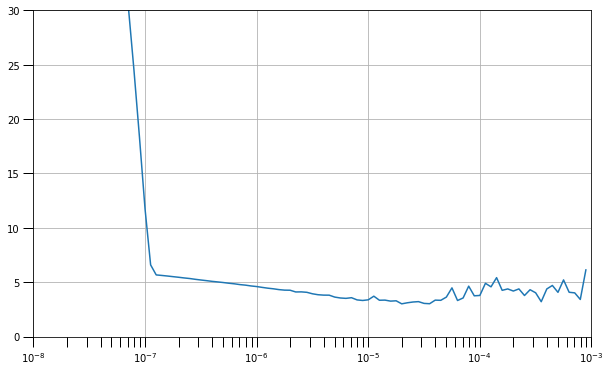

In [10]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 30])

# FROM THIS PICK A LEARNING RATE


##Train with choosen Learning Rate

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = create_uncompiled_model()

model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=5e-6, momentum=.9),
                metrics=['mae'])


history = model.fit(dataset, epochs=50)
    

Epoch 1/50
34/34 [==============================] - 5s 11ms/step - loss: 18.5422 - mae: 19.0329
Epoch 2/50
34/34 [==============================] - 0s 10ms/step - loss: 5.4856 - mae: 5.9542
Epoch 3/50
34/34 [==============================] - 0s 10ms/step - loss: 4.5677 - mae: 5.0376
Epoch 4/50
34/34 [==============================] - 0s 10ms/step - loss: 4.3550 - mae: 4.8188
Epoch 5/50
34/34 [==============================] - 0s 10ms/step - loss: 4.1492 - mae: 4.6174
Epoch 6/50
34/34 [==============================] - 0s 11ms/step - loss: 4.0540 - mae: 4.5186
Epoch 7/50
34/34 [==============================] - 0s 10ms/step - loss: 3.9429 - mae: 4.4104
Epoch 8/50
34/34 [==============================] - 0s 10ms/step - loss: 3.8026 - mae: 4.2676
Epoch 9/50
34/34 [==============================] - 0s 10ms/step - loss: 3.7390 - mae: 4.2038
Epoch 10/50
34/34 [==============================] - 0s 10ms/step - loss: 3.6354 - mae: 4.1006
Epoch 11/50
34/34 [==============================] - 0s 1

##Evaluating the forecast


In [18]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [19]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

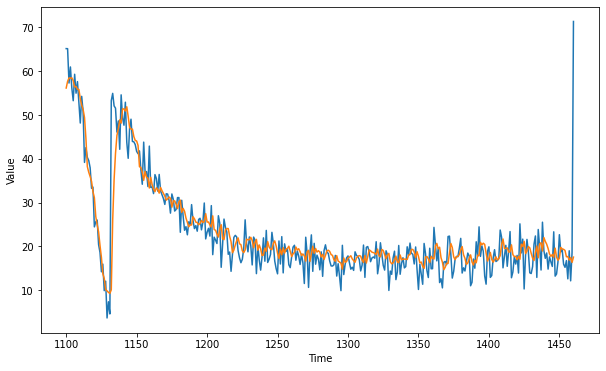

In [20]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_val, series_val)
plot_series(time_val, rnn_forecast)

In [21]:
mse, mae = compute_metrics(series_val, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 30.01, mae: 3.31 for forecast
